<a href="https://colab.research.google.com/github/pripri99/Floorplan-Generation/blob/main/Pix2Pix_test_image_cubicasa_as_pixel_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Source NN architecture: https://machinelearningmastery.com/how-to-develop-a-pix2pix-gan-for-image-to-image-translation/ 


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# Pix2Pix for Cubicasa5k Data
import numpy as np
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
import matplotlib.pyplot as plt


In [ ]:
# define the discriminator model
def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    in_src_image = Input(shape=image_shape)
    # target image input
    in_target_image = Input(shape=image_shape)
    # concatenate images channel-wise
    merged = Concatenate()([in_src_image, in_target_image])
    # C64
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    # C128
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    # define model
    model = Model([in_src_image, in_target_image], patch_out)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

In [ ]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g


In [ ]:
# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # encoder model
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    # decoder model
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)
    # output
    g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    return model


In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # define the source image
    in_src = Input(shape=image_shape)
    # connect the source image to the generator input
    gen_out = g_model(in_src)
    # connect the source input and generator output to the discriminator input
    dis_out = d_model([in_src, gen_out])
    # src image as input, generated image and classification output
    model = Model(in_src, [dis_out, gen_out])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
    return model


In [ ]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset
    # choose random instances
    ix = randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y


In [ ]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0

    plt.figure(figsize=(20, 20))
    # plot real source images
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA[i])
    # plot generated target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_fakeB[i])
    # plot real target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(X_realB[i])
    # save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    plt.savefig(filename1)
    plt.close()
    # save the generator model
    filename2 = 'model_%06d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

In [ ]:
# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        # summarize model performance
        if (i+1) % (bat_per_epo * 10) == 0:
            summarize_performance(i, g_model, dataset)

In [ ]:
# load and prepare training images
def load_real_samples(filename):
    
    
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

In [ ]:
# load and prepare training images
def load_real_samplesV2(filename):
    
    # unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load compressed arrays image data
data = load('/content/drive/My Drive/CubiCasa5k plans_256V2.npz')
type(data)

numpy.lib.npyio.NpzFile

In [ ]:
# unpack arrays
X1, X2 = data['arr_0'].astype(int), data['arr_1'].astype(int)

In [ ]:
import numpy as np

print(type(X2))
print(np.min(X1))
print(np.min(X2))
print(np.max(X1))
print(np.max(X2))

<class 'numpy.ndarray'>
0
0
255
255


In [ ]:
X1 = X1.astype(int)
X2 = X2.astype(int)

In [ ]:
print(np.min(X1))
print(np.min(X2))
print(np.max(X1))
print(np.max(X2))

0
255
255


In [ ]:
X1 = (X1 - 127.5) / 127.5
X2 = (X2 - 127.5) / 127.5

In [ ]:
print(np.min(X1))
print(np.min(X2))
print(np.max(X1))
print(np.max(X2))

-1.0
-1.0
1.0
1.0


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1, X2, test_size=0.11, random_state=11)

In [ ]:
X_train.shape

(3105, 256, 256, 3)

In [ ]:
dataset = [X_train, y_train] 

In [ ]:
#unpack image data
#dataset = load_real_samples(data)
#print('Loaded', dataset[0].shape, dataset[1].shape)

In [ ]:
bat_per_epo = int(len(dataset[0]) / 1)
# calculate the number of training iterations
n_steps = bat_per_epo * 100
print(n_steps)

310500


In [ ]:
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
print(image_shape)

(256, 256, 3)


In [ ]:
from keras.models import load_model
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
g_model = load_model('model_314000.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# train model
train(d_model, g_model, gan_model, dataset)

Streaming output truncated to the last 5000 lines.
>212840, d1[0.000] d2[0.000] g[1.071]
>212841, d1[0.000] d2[0.000] g[1.403]
>212842, d1[0.178] d2[0.000] g[1.092]
>212843, d1[0.001] d2[0.340] g[1.624]
>212844, d1[0.000] d2[0.000] g[1.757]
>212845, d1[0.007] d2[0.000] g[0.923]
>212846, d1[0.017] d2[0.000] g[1.141]
>212847, d1[0.011] d2[0.000] g[1.787]
>212848, d1[0.000] d2[0.000] g[1.176]
>212849, d1[0.811] d2[0.009] g[1.588]
>212850, d1[0.000] d2[0.014] g[1.812]
>212851, d1[0.000] d2[0.000] g[1.543]
>212852, d1[0.000] d2[0.001] g[1.233]
>212853, d1[0.000] d2[0.203] g[2.127]
>212854, d1[0.000] d2[0.019] g[1.363]
>212855, d1[0.000] d2[0.000] g[1.402]
>212856, d1[0.000] d2[0.000] g[0.969]
>212857, d1[0.000] d2[0.006] g[1.767]
>212858, d1[0.000] d2[0.002] g[1.580]
>212859, d1[0.000] d2[0.000] g[1.758]
>212860, d1[0.000] d2[0.000] g[0.898]
>212861, d1[0.000] d2[0.000] g[1.735]
>212862, d1[0.000] d2[0.000] g[1.677]
>212863, d1[0.000] d2[0.000] g[1.391]
>212864, d1[0.000] d2[0.000] g[1.055]

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f00f00f6950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


>217838, d1[0.000] d2[0.000] g[1.617]
>217839, d1[0.000] d2[0.000] g[0.907]
>217840, d1[0.000] d2[0.000] g[0.916]
>217841, d1[0.000] d2[0.000] g[1.773]
>217842, d1[0.000] d2[0.000] g[1.918]
>217843, d1[0.000] d2[0.000] g[1.282]
>217844, d1[0.000] d2[0.000] g[1.286]
>217845, d1[0.000] d2[0.000] g[0.896]
>217846, d1[0.000] d2[0.000] g[1.795]
>217847, d1[0.000] d2[0.000] g[1.446]
>217848, d1[0.000] d2[0.000] g[1.652]
>217849, d1[0.000] d2[0.000] g[1.325]
>217850, d1[0.000] d2[0.000] g[1.748]
>217851, d1[0.000] d2[0.001] g[1.933]
>217852, d1[0.000] d2[0.000] g[0.804]
>217853, d1[0.000] d2[0.000] g[1.161]
>217854, d1[0.000] d2[0.003] g[1.784]
>217855, d1[0.000] d2[0.000] g[2.102]
>217856, d1[0.000] d2[0.000] g[1.180]
>217857, d1[0.000] d2[0.000] g[1.437]
>217858, d1[0.000] d2[0.000] g[1.227]
>217859, d1[0.000] d2[0.000] g[1.748]
>217860, d1[0.000] d2[0.000] g[1.376]


KeyboardInterrupt: ignored

In [ ]:
#d1 = loss discriminator on real sample
#d2 = loss discriminator on generated samples
#g = loss generator

In [ ]:
# example of loading a pix2pix model and using it for image to image translation
from keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import plt
from numpy.random import randint
 
# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]
 
# plot source, generated and target images
def plot_images(src_img, gen_img, tar_img, ix):
  images = vstack((src_img, gen_img, tar_img))
  # scale from [-1,1] to [0,1]
  images = (images + 1) / 2.0
  titles = ['Source', 'Generated', 'Expected']

  plt.figure(figsize=(20, 20))
  # plot images row by row
  for i in range(len(images)):
    # define subplot
    plt.subplot(1, 3, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(images[i])
    # show title
    plt.title(titles[i])
  
  filename1 = 'plot_%2d.png' % (ix)
  plt.savefig(filename1)
  print('>Saved: %s' % (filename1))
  plt.show()
 
# load dataset
[X1, X2] = [X_test, y_test]
print('Loaded', X1.shape, X2.shape)
# load model
model = load_model('model_031050.h5')



Loaded (384, 256, 256, 3) (384, 256, 256, 3)


[97]
>Saved: plot_97.png


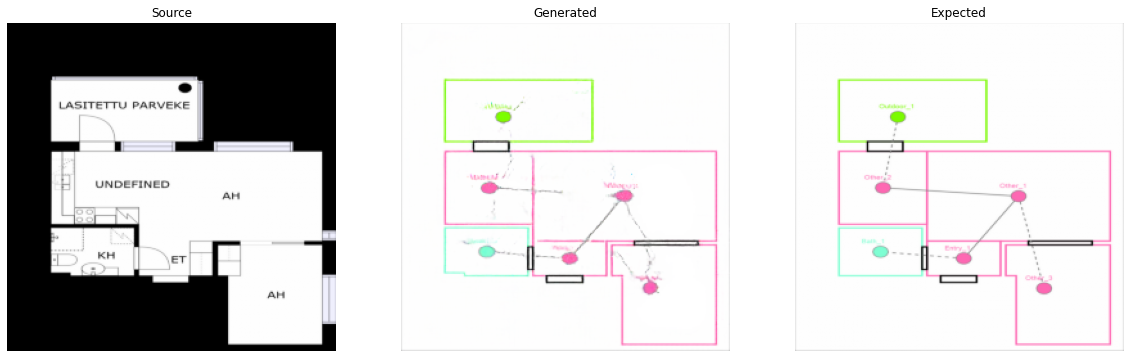

In [ ]:
# select random example
ix = randint(0, len(X1), 1)
print(ix)
src_image, tar_image = X1[ix], X2[ix]
# generate image from source
gen_image = model.predict(src_image)
# plot all three images
plot_images(src_image, gen_image, tar_image, ix)